In [1]:
model_checkpoint = "google/vit-base-patch16-224" # pre-trained model from which to fine-tune
batch_size = 32 # batch size for training and evaluation

In [2]:
!pip install -q datasets transformers

In [3]:
! pip install -U accelerate
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 5.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.22.0
    Uninstalling accelerate-0.22.0:
      Successfully uninstalled accelerate-0.22.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 47.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.33.0
    Uninstalling transformers-4.33.0:
      Successfully uninstalled transformers-4.33.0


In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [6]:
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir="/kaggle/input/paperdata")

Resolving data files:   0%|          | 0/40154 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset image_folder downloaded and prepared to /root/.cache/huggingface/datasets/image_folder/default-c8bdbabd708d47ff/0.0.0/ee92df8e96c6907f3c851a987be3fd03d4b93b247e727b69a8e23ac94392a091. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
from datasets import load_metric

metric = load_metric("accuracy")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 40154
    })
})

In [9]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=31, names=['Basal Cell Carcinoma', 'Darier_s Disease', 'Epidermolysis Bullosa Pruriginosa', 'Hailey-Hailey Disease', 'Herpes Simplex', 'Impetigo', 'Larva Migrans', 'Leprosy Borderline', 'Leprosy Lepromatous', 'Leprosy Tuberculoid', 'Lichen Planus', 'Lupus Erythematosus Chronicus Discoides', 'Melanoma', 'Molluscum Contagiosum', 'Mycosis Fungoides', 'Neurofibromatosis', 'Papilomatosis Confluentes And Reticulate', 'Pediculosis Capitis', 'Pityriasis Rosea', 'Porokeratosis Actinic', 'Psoriasis', 'Tinea Corporis', 'Tinea Nigra', 'Tungiasis', 'actinic keratosis', 'dermatofibroma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'], id=None)}

In [10]:
example = dataset["train"][10]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=479x368>,
 'label': 0}

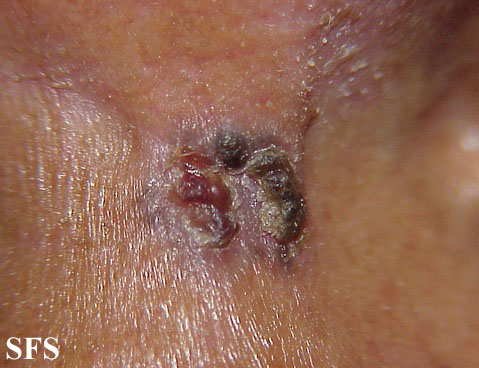

In [11]:
example['image']

In [12]:
example['label']

0

In [13]:
dataset["train"].features["label"]

ClassLabel(num_classes=31, names=['Basal Cell Carcinoma', 'Darier_s Disease', 'Epidermolysis Bullosa Pruriginosa', 'Hailey-Hailey Disease', 'Herpes Simplex', 'Impetigo', 'Larva Migrans', 'Leprosy Borderline', 'Leprosy Lepromatous', 'Leprosy Tuberculoid', 'Lichen Planus', 'Lupus Erythematosus Chronicus Discoides', 'Melanoma', 'Molluscum Contagiosum', 'Mycosis Fungoides', 'Neurofibromatosis', 'Papilomatosis Confluentes And Reticulate', 'Pediculosis Capitis', 'Pityriasis Rosea', 'Porokeratosis Actinic', 'Psoriasis', 'Tinea Corporis', 'Tinea Nigra', 'Tungiasis', 'actinic keratosis', 'dermatofibroma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'], id=None)

In [14]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'Epidermolysis Bullosa Pruriginosa'

In [15]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [16]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [17]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [18]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [19]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=503x377>,
 'label': 0,
 'pixel_values': tensor([[[ 0.3882,  0.4196,  0.4510,  ...,  0.9059,  0.9059,  0.9137],
          [ 0.3961,  0.4196,  0.4431,  ...,  0.9216,  0.9137,  0.9216],
          [ 0.4039,  0.4196,  0.4353,  ...,  0.9451,  0.9373,  0.9373],
          ...,
          [ 0.2863,  0.2784,  0.2627,  ...,  0.5765,  0.5765,  0.5765],
          [ 0.2863,  0.2784,  0.2706,  ...,  0.5529,  0.5608,  0.5451],
          [ 0.2863,  0.2784,  0.2706,  ...,  0.5451,  0.5451,  0.5216]],
 
         [[-0.0196,  0.0039,  0.0275,  ...,  0.4980,  0.4980,  0.4902],
          [-0.0196, -0.0039,  0.0118,  ...,  0.5059,  0.4980,  0.4902],
          [-0.0196, -0.0118, -0.0118,  ...,  0.5137,  0.5059,  0.4980],
          ...,
          [-0.2314, -0.2392, -0.2549,  ...,  0.1059,  0.1137,  0.1137],
          [-0.2314, -0.2471, -0.2627,  ...,  0.0902,  0.0980,  0.0824],
          [-0.2314, -0.2471, -0.2627,  ...,  0.0824,  0.0824,  0.0588]]

In [20]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([31]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([31, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.33.2', '0.23.0')

In [22]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"vit_base_patch16_224-finetuned-SkinDisease",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [23]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [24]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [25]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [26]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
0,0.909900,0.824755,0.764691
2,0.584800,0.423648,0.874751
2,0.395200,0.315403,0.902141
4,0.395700,0.269506,0.910608
4,0.314600,0.238122,0.919821
6,0.288300,0.240741,0.921813
6,0.226400,0.216044,0.927789
8,0.233900,0.212142,0.928287
8,0.196600,0.204389,0.930279
9,0.236600,0.199227,0.934263


***** train metrics *****
  epoch                    =          9.98
  total_flos               = 26042974985GF
  train_loss               =        0.5066
  train_runtime            =    3:20:45.01
  train_samples_per_second =        30.002
  train_steps_per_second   =         0.234


In [27]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       9.98
  eval_accuracy           =     0.9343
  eval_loss               =     0.1992
  eval_runtime            = 0:01:13.06
  eval_samples_per_second =     54.968
  eval_steps_per_second   =      1.725


In [28]:
trainer.push_to_hub()

'https://huggingface.co/Jayanth2002/vit_base_patch16_224-finetuned-SkinDisease/tree/main/'

DINO V2 Test 

In [19]:
from transformers import AutoModelForImageClassification, AutoImageProcessor
from sklearn.metrics import accuracy_score
import torch

# Load the pre-trained model and image processor
repo_name = "Jayanth2002/dinov2-base-finetuned-SkinDisease"
image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

# Load and preprocess the test images
test_data_dir = "/kaggle/input/paperdata/test"  # Path to the test data directory
test_images = load_dataset("imagefolder", data_dir=test_data_dir)

# Preprocess the test images
test_images.set_transform(preprocess_val)  # Use the same validation transforms

# Create a test dataset
test_ds = test_images["train"]  # Use the "train" split for the test data




Resolving data files:   0%|          | 0/994 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
test_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 994
})

In [20]:
# Initialize lists to store predicted and actual labels
predicted_labels = []
actual_labels = []

# Iterate through the test dataset and make predictions
for example in test_ds:
    image = example["image"]
    encoding = image_processor(image.convert("RGB"), return_tensors="pt")

    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits

    predicted_class_idx = logits.argmax(-1).item()
    predicted_labels.append(predicted_class_idx)
    actual_labels.append(example["label"])

# Calculate accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)



In [21]:
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9557


Soft voting between Dino v2 and Swin Transformers

In [12]:
from transformers import AutoModelForImageClassification, AutoImageProcessor
from sklearn.metrics import accuracy_score
import torch

# Load the pretrained Swin Transformer model and image processor
swin_repo_name = "Jayanth2002/swin-base-patch4-window7-224-finetuned-SkinDisease"
swin_image_processor = AutoImageProcessor.from_pretrained(swin_repo_name)
swin_model = AutoModelForImageClassification.from_pretrained(swin_repo_name)

# Load the pretrained Vision Transformer (ViT) model and image processor
vit_repo_name = "Jayanth2002/dinov2-base-finetuned-SkinDisease"
vit_image_processor = AutoImageProcessor.from_pretrained(vit_repo_name)
vit_model = AutoModelForImageClassification.from_pretrained(vit_repo_name)

# Load and preprocess the test images
test_data_dir = "/kaggle/input/paperdata/test"  # Path to the test data directory
test_images = load_dataset("imagefolder", data_dir=test_data_dir)

# Preprocess the test images
test_images.set_transform(preprocess_val)  # Use the same validation transforms

# Create a test dataset
test_ds = test_images["train"]  # Use the "train" split for the test data

# Initialize lists to store predicted and actual labels
predicted_labels = []
actual_labels = []

# Iterate through the test dataset and make predictions with both models
for example in test_ds:
    image = example["image"]
    encoding_swin = swin_image_processor(image.convert("RGB"), return_tensors="pt")
    encoding_vit = vit_image_processor(image.convert("RGB"), return_tensors="pt")

    with torch.no_grad():
        swin_outputs = swin_model(**encoding_swin)
        swin_logits = swin_outputs.logits
        vit_outputs = vit_model(**encoding_vit)
        vit_logits = vit_outputs.logits

    # Perform soft voting between Swin Transformer and ViT models
    swin_class_idx = swin_logits.argmax(-1).item()
    vit_class_idx = vit_logits.argmax(-1).item()

    if swin_class_idx == vit_class_idx:
        # Both models agree on the same class, so select that class
        predicted_labels.append(swin_class_idx)
    else:
        # Models disagree, choose the class with the higher probability
        swin_prob = swin_logits.softmax(dim=-1).max().item()
        vit_prob = vit_logits.softmax(dim=-1).max().item()
        if swin_prob > vit_prob:
            predicted_labels.append(swin_class_idx)
        else:
            predicted_labels.append(vit_class_idx)

    actual_labels.append(example["label"])

# Calculate accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)


Resolving data files:   0%|          | 0/994 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9427


SWIN_Test

In [14]:
from transformers import AutoModelForImageClassification, AutoImageProcessor
from sklearn.metrics import accuracy_score
import torch

# Load the pre-trained model and image processor
repo_name = "Jayanth2002/swin-base-patch4-window7-224-finetuned-SkinDisease"
image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

# Load and preprocess the test images
test_data_dir = "/kaggle/input/paperdata/test"  # Path to the test data directory
test_images = load_dataset("imagefolder", data_dir=test_data_dir)

# Preprocess the test images
test_images.set_transform(preprocess_val)  # Use the same validation transforms

# Create a test dataset
test_ds = test_images["train"]  # Use the "train" split for the test data





Resolving data files:   0%|          | 0/994 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
# Initialize lists to store predicted and actual labels
predicted_labels = []
actual_labels = []

# Iterate through the test dataset and make predictions
for example in test_ds:
    image = example["image"]
    encoding = image_processor(image.convert("RGB"), return_tensors="pt")

    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits

    predicted_class_idx = logits.argmax(-1).item()
    predicted_labels.append(predicted_class_idx)
    actual_labels.append(example["label"])

# Calculate accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)

print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9044


VIT_Test

In [29]:
from transformers import AutoModelForImageClassification, AutoImageProcessor
from sklearn.metrics import accuracy_score
import torch

# Load the pre-trained model and image processor
repo_name = "Jayanth2002/vit_base_patch16_224-finetuned-SkinDisease"
image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

# Load and preprocess the test images
test_data_dir = "/kaggle/input/paperdata/test"  # Path to the test data directory
test_images = load_dataset("imagefolder", data_dir=test_data_dir)

# Preprocess the test images
test_images.set_transform(preprocess_val)  # Use the same validation transforms

# Create a test dataset
test_ds = test_images["train"]  # Use the "train" split for the test data





Resolving data files:   0%|          | 0/994 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset image_folder downloaded and prepared to /root/.cache/huggingface/datasets/image_folder/default-51fcf52611593cec/0.0.0/ee92df8e96c6907f3c851a987be3fd03d4b93b247e727b69a8e23ac94392a091. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
# Initialize lists to store predicted and actual labels
predicted_labels = []
actual_labels = []

# Iterate through the test dataset and make predictions
for example in test_ds:
    image = example["image"]
    encoding = image_processor(image.convert("RGB"), return_tensors="pt")

    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits

    predicted_class_idx = logits.argmax(-1).item()
    predicted_labels.append(predicted_class_idx)
    actual_labels.append(example["label"])

# Calculate accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)

print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9437
